In [2]:
import numpy as np
import time
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from matplotlib import pyplot as plt

In [3]:
latent_dim = 100

img_rows, img_cols = 28, 28
img_channels = 1
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channels)
x_train = x_train.astype('float32')
x_train /= 255

## Generator

The generator synthesizes new images from a 100-dimensional noise (uniform distribution between -1.0 to 1.0) using the inverse of convolution, called transposed convolution. Instead of fractionally-strided convolution as suggested in DCGAN, upsampling between the first three layers is used since it synthesizes more realistic handwriting images. In between layers, batch normalization stabilizes learning. The activation function after each layer is a ReLU. The output of the sigmoid at the last layer produces the fake image. Dropout of between 0.3 and 0.5 at the first layer prevents overfitting.

In [4]:
def generator_model(): 
    dropout = 0.4
    depth = 256 # 64+64+64+64
    dim = 7
    
    model = Sequential()
    # In: 100
    # Out: dim x dim x depth
    model.add(Dense(dim*dim*depth, input_dim=latent_dim))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))
    model.add(Reshape((dim, dim, depth)))
    model.add(Dropout(dropout))

    # In: dim x dim x depth
    # Out: 2*dim x 2*dim x depth/2
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    model.add(UpSampling2D())
    model.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Activation('relu'))

    # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
    model.add(Conv2DTranspose(1, 5, padding='same'))
    model.add(Activation('sigmoid'))
    
    return model

## Discriminator

A discriminator that tells how real an image is, is basically a deep Convolutional Neural Network. For MNIST Dataset, the input is an image (28 pixel x 28 pixel x 1 channel). The sigmoid output is a scalar value of the probability of how real the image is (0.0 is certainly fake, 1.0 is certainly real, anything in between is a gray area). The difference from a typical CNN is the absence of max-pooling in between layers. Instead, a strided convolution is used for downsampling. The activation function used in each CNN layer is a leaky ReLU. A dropout between 0.4 and 0.7 between layers prevent over fitting and memorization. 

In [5]:
# (W−F+2P)/S+1
def discriminator_model():
    depth = 64
    dropout = 0.4
    input_shape = (img_rows, img_cols, img_channels)
    
    model = Sequential()
    # In: 28 x 28 x 1, depth = 1
    # Out: 14 x 14 x 1, depth=64
    model.add(Conv2D(depth, 5, strides=2, input_shape=input_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*2, 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*4, 5, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    model.add(Conv2D(depth*8, 5, strides=1, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropout))

    # Out: 1-dim probability
    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

# GAN model

## Discriminator model

Since the output of the Discriminator is sigmoid, we use binary cross entropy for the loss. RMSProp as optimizer generates more realistic fake images compared to Adam for this case. Learning rate is 0.0008. Weight decay and clip value stabilize learning during the latter part of the training. You have to adjust the decay if you adjust the learning rate.

In [6]:
discriminator = discriminator_model()
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=RMSprop(lr=0.0002, decay=6e-8), 
                      metrics=['accuracy'])

In [7]:
generator = generator_model()

## Adversarial model

The adversarial model is just the generator-discriminator stacked together. The training parameters are the same as in the Discriminator model except for a reduced learning rate and corresponding weight decay.

In [8]:
def adversarial_model():
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(lr=0.0001, decay=3e-8), 
                  metrics=['accuracy'])
    discriminator.trainable = True
    return model

In [9]:
adversarial = adversarial_model()

## Training

In [10]:
def plot_images(saveToFile=False, fake=True, samples=16, noise=None, epoch=0):
    filename = 'mnist.png'
    if fake:
        if noise is None:
            noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
        else:
            filename = "mnist_%d.png" % epoch
        images = generator.predict(noise)
    else:
        i = np.random.randint(0, x_train.shape[0], samples)
        images = x_train[i, :, :, :]

    plt.figure(figsize=(10,10))
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [img_rows, img_cols])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    if saveToFile:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()

We determine first if Discriminator model is correct by training it alone with real and fake images. Afterwards, the Discriminator and Adversarial models are trained one after the other. 

In [11]:
def train(train_epochs=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for epoch in range(train_epochs):
            
            # ---------------------
            #  Train Discriminator
            # ---------------------
            
            # select a random half of images
            images_train = x_train[np.random.randint(0, x_train.shape[0], size=batch_size), :, :, :]
            
            # sample noise and generate a batch of new images
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_dim])
            images_fake = generator.predict(noise)
            
            # train the discriminator (real classified as ones and generated as zeros)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = discriminator.train_on_batch(x, y)

            # ---------------------
            #  Train Generator
            # ---------------------
            
            # train the generator (wants discriminator to mistake images as real)
            y = np.ones([batch_size, 1])
            a_loss = adversarial.train_on_batch(noise, y)
            
            log_msg = "%d: [D loss: %f, acc: %f]" % (epoch, d_loss[0], d_loss[1])
            log_msg = "%s  [A loss: %f, acc: %f]" % (log_msg, a_loss[0], a_loss[1])
            print(log_msg)
            if save_interval>0:
                if (epoch+1)%save_interval==0:
                    plot_images(saveToFile=True, samples=noise_input.shape[0],
                                noise=noise_input, epoch=(epoch+1))

In [12]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))

D:\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.693539, acc: 0.500000]  [A loss: 0.956172, acc: 0.000000]
1: [D loss: 0.562464, acc: 0.742188]  [A loss: 2.677871, acc: 0.000000]
2: [D loss: 0.474760, acc: 0.560547]  [A loss: 0.200526, acc: 1.000000]
3: [D loss: 1.137499, acc: 0.500000]  [A loss: 1.798508, acc: 0.000000]
4: [D loss: 0.380512, acc: 0.851562]  [A loss: 1.714468, acc: 0.000000]
5: [D loss: 0.351728, acc: 0.925781]  [A loss: 1.873793, acc: 0.000000]
6: [D loss: 0.307240, acc: 0.941406]  [A loss: 2.027952, acc: 0.000000]
7: [D loss: 0.266801, acc: 0.960938]  [A loss: 2.292771, acc: 0.000000]
8: [D loss: 0.245314, acc: 0.957031]  [A loss: 2.953331, acc: 0.000000]
9: [D loss: 0.235584, acc: 0.970703]  [A loss: 4.526452, acc: 0.000000]
10: [D loss: 0.272482, acc: 0.945312]  [A loss: 2.217271, acc: 0.000000]
11: [D loss: 0.204847, acc: 0.996094]  [A loss: 9.157019, acc: 0.000000]
12: [D loss: 0.780241, acc: 0.650391]  [A loss: 1.176475, acc: 0.093750]
13: [D loss: 0.502586, acc: 0.568359]  [A loss: 4.893988, acc

113: [D loss: 0.386682, acc: 0.777344]  [A loss: 2.274062, acc: 0.000000]
114: [D loss: 0.527881, acc: 0.746094]  [A loss: 0.445689, acc: 0.898438]
115: [D loss: 0.636621, acc: 0.523438]  [A loss: 2.138530, acc: 0.000000]
116: [D loss: 0.562240, acc: 0.679688]  [A loss: 0.672262, acc: 0.542969]
117: [D loss: 0.472387, acc: 0.644531]  [A loss: 1.574728, acc: 0.000000]
118: [D loss: 0.362421, acc: 0.896484]  [A loss: 1.025136, acc: 0.101562]
119: [D loss: 0.367784, acc: 0.894531]  [A loss: 1.410415, acc: 0.007812]
120: [D loss: 0.352501, acc: 0.927734]  [A loss: 1.061459, acc: 0.089844]
121: [D loss: 0.359084, acc: 0.894531]  [A loss: 1.601008, acc: 0.000000]
122: [D loss: 0.363573, acc: 0.898438]  [A loss: 0.914339, acc: 0.207031]
123: [D loss: 0.397464, acc: 0.796875]  [A loss: 2.335611, acc: 0.000000]
124: [D loss: 0.524644, acc: 0.695312]  [A loss: 0.361207, acc: 0.957031]
125: [D loss: 0.776260, acc: 0.509766]  [A loss: 2.279074, acc: 0.000000]
126: [D loss: 0.568325, acc: 0.660156]

224: [D loss: 0.595666, acc: 0.632812]  [A loss: 0.633501, acc: 0.597656]
225: [D loss: 0.593770, acc: 0.634766]  [A loss: 1.323122, acc: 0.035156]
226: [D loss: 0.575680, acc: 0.666016]  [A loss: 0.605157, acc: 0.660156]
227: [D loss: 0.597288, acc: 0.625000]  [A loss: 1.485978, acc: 0.003906]
228: [D loss: 0.609621, acc: 0.636719]  [A loss: 0.602165, acc: 0.660156]
229: [D loss: 0.604272, acc: 0.634766]  [A loss: 1.490407, acc: 0.003906]
230: [D loss: 0.633957, acc: 0.607422]  [A loss: 0.593126, acc: 0.679688]
231: [D loss: 0.619158, acc: 0.593750]  [A loss: 1.404156, acc: 0.007812]
232: [D loss: 0.619326, acc: 0.611328]  [A loss: 0.603144, acc: 0.695312]
233: [D loss: 0.616350, acc: 0.613281]  [A loss: 1.383846, acc: 0.000000]
234: [D loss: 0.622171, acc: 0.648438]  [A loss: 0.653296, acc: 0.605469]
235: [D loss: 0.594664, acc: 0.648438]  [A loss: 1.285559, acc: 0.035156]
236: [D loss: 0.585468, acc: 0.679688]  [A loss: 0.674323, acc: 0.601562]
237: [D loss: 0.580615, acc: 0.679688]

335: [D loss: 0.643596, acc: 0.613281]  [A loss: 1.206763, acc: 0.027344]
336: [D loss: 0.672256, acc: 0.580078]  [A loss: 0.603296, acc: 0.695312]
337: [D loss: 0.652526, acc: 0.595703]  [A loss: 1.165149, acc: 0.042969]
338: [D loss: 0.660601, acc: 0.593750]  [A loss: 0.594833, acc: 0.718750]
339: [D loss: 0.680162, acc: 0.566406]  [A loss: 1.144989, acc: 0.015625]
340: [D loss: 0.662974, acc: 0.587891]  [A loss: 0.728677, acc: 0.437500]
341: [D loss: 0.643265, acc: 0.644531]  [A loss: 0.974836, acc: 0.128906]
342: [D loss: 0.630771, acc: 0.640625]  [A loss: 0.738804, acc: 0.429688]
343: [D loss: 0.622449, acc: 0.662109]  [A loss: 0.946538, acc: 0.171875]
344: [D loss: 0.640613, acc: 0.623047]  [A loss: 0.694506, acc: 0.558594]
345: [D loss: 0.635268, acc: 0.652344]  [A loss: 1.010041, acc: 0.097656]
346: [D loss: 0.636800, acc: 0.625000]  [A loss: 0.614726, acc: 0.636719]
347: [D loss: 0.644710, acc: 0.603516]  [A loss: 1.222802, acc: 0.007812]
348: [D loss: 0.694291, acc: 0.550781]

446: [D loss: 0.669111, acc: 0.585938]  [A loss: 0.560560, acc: 0.757812]
447: [D loss: 0.687883, acc: 0.542969]  [A loss: 1.256462, acc: 0.027344]
448: [D loss: 0.685903, acc: 0.550781]  [A loss: 0.629171, acc: 0.640625]
449: [D loss: 0.651666, acc: 0.593750]  [A loss: 0.995144, acc: 0.125000]
450: [D loss: 0.662650, acc: 0.607422]  [A loss: 0.757551, acc: 0.402344]
451: [D loss: 0.640205, acc: 0.623047]  [A loss: 0.855874, acc: 0.277344]
452: [D loss: 0.632585, acc: 0.644531]  [A loss: 0.817666, acc: 0.328125]
453: [D loss: 0.642405, acc: 0.628906]  [A loss: 0.880526, acc: 0.226562]
454: [D loss: 0.633849, acc: 0.652344]  [A loss: 0.790705, acc: 0.363281]
455: [D loss: 0.634682, acc: 0.660156]  [A loss: 0.866527, acc: 0.285156]
456: [D loss: 0.640182, acc: 0.642578]  [A loss: 0.980631, acc: 0.160156]
457: [D loss: 0.652448, acc: 0.621094]  [A loss: 0.738720, acc: 0.457031]
458: [D loss: 0.642246, acc: 0.623047]  [A loss: 0.983707, acc: 0.164062]
459: [D loss: 0.652074, acc: 0.623047]

557: [D loss: 0.646170, acc: 0.613281]  [A loss: 0.810025, acc: 0.382812]
558: [D loss: 0.611659, acc: 0.693359]  [A loss: 0.953145, acc: 0.214844]
559: [D loss: 0.638246, acc: 0.644531]  [A loss: 0.851961, acc: 0.312500]
560: [D loss: 0.649944, acc: 0.621094]  [A loss: 0.908290, acc: 0.222656]
561: [D loss: 0.641289, acc: 0.628906]  [A loss: 0.831644, acc: 0.347656]
562: [D loss: 0.629363, acc: 0.644531]  [A loss: 0.989557, acc: 0.171875]
563: [D loss: 0.634185, acc: 0.648438]  [A loss: 0.791022, acc: 0.378906]
564: [D loss: 0.615703, acc: 0.660156]  [A loss: 1.048377, acc: 0.136719]
565: [D loss: 0.637846, acc: 0.636719]  [A loss: 0.719162, acc: 0.503906]
566: [D loss: 0.636875, acc: 0.630859]  [A loss: 1.116626, acc: 0.074219]
567: [D loss: 0.647944, acc: 0.619141]  [A loss: 0.744988, acc: 0.511719]
568: [D loss: 0.668266, acc: 0.562500]  [A loss: 0.990476, acc: 0.140625]
569: [D loss: 0.629325, acc: 0.648438]  [A loss: 0.759700, acc: 0.445312]
570: [D loss: 0.643833, acc: 0.605469]

668: [D loss: 0.616934, acc: 0.625000]  [A loss: 0.931803, acc: 0.273438]
669: [D loss: 0.644003, acc: 0.628906]  [A loss: 0.969275, acc: 0.234375]
670: [D loss: 0.598340, acc: 0.677734]  [A loss: 0.816346, acc: 0.363281]
671: [D loss: 0.603416, acc: 0.695312]  [A loss: 1.180246, acc: 0.082031]
672: [D loss: 0.635935, acc: 0.638672]  [A loss: 0.664989, acc: 0.562500]
673: [D loss: 0.636071, acc: 0.630859]  [A loss: 1.226608, acc: 0.054688]
674: [D loss: 0.656289, acc: 0.587891]  [A loss: 0.752298, acc: 0.468750]
675: [D loss: 0.639611, acc: 0.626953]  [A loss: 1.092704, acc: 0.093750]
676: [D loss: 0.621002, acc: 0.656250]  [A loss: 0.792616, acc: 0.425781]
677: [D loss: 0.614039, acc: 0.667969]  [A loss: 1.030976, acc: 0.152344]
678: [D loss: 0.614120, acc: 0.664062]  [A loss: 0.870143, acc: 0.324219]
679: [D loss: 0.614285, acc: 0.687500]  [A loss: 0.997979, acc: 0.199219]
680: [D loss: 0.631558, acc: 0.660156]  [A loss: 0.843658, acc: 0.378906]
681: [D loss: 0.597871, acc: 0.677734]

779: [D loss: 0.610653, acc: 0.685547]  [A loss: 1.021777, acc: 0.210938]
780: [D loss: 0.615307, acc: 0.664062]  [A loss: 0.939581, acc: 0.308594]
781: [D loss: 0.617495, acc: 0.640625]  [A loss: 1.114431, acc: 0.125000]
782: [D loss: 0.586599, acc: 0.718750]  [A loss: 0.822694, acc: 0.371094]
783: [D loss: 0.630162, acc: 0.646484]  [A loss: 1.193369, acc: 0.117188]
784: [D loss: 0.636074, acc: 0.662109]  [A loss: 0.801607, acc: 0.421875]
785: [D loss: 0.623777, acc: 0.666016]  [A loss: 1.129213, acc: 0.144531]
786: [D loss: 0.620660, acc: 0.664062]  [A loss: 0.834948, acc: 0.382812]
787: [D loss: 0.609194, acc: 0.666016]  [A loss: 1.100695, acc: 0.144531]
788: [D loss: 0.612077, acc: 0.660156]  [A loss: 0.856646, acc: 0.347656]
789: [D loss: 0.594409, acc: 0.675781]  [A loss: 1.154695, acc: 0.160156]
790: [D loss: 0.617921, acc: 0.685547]  [A loss: 0.937597, acc: 0.292969]
791: [D loss: 0.618236, acc: 0.644531]  [A loss: 1.161213, acc: 0.113281]
792: [D loss: 0.617496, acc: 0.644531]

890: [D loss: 0.621539, acc: 0.660156]  [A loss: 1.207441, acc: 0.089844]
891: [D loss: 0.616724, acc: 0.636719]  [A loss: 0.776940, acc: 0.468750]
892: [D loss: 0.595741, acc: 0.685547]  [A loss: 1.179262, acc: 0.101562]
893: [D loss: 0.610534, acc: 0.669922]  [A loss: 0.973553, acc: 0.261719]
894: [D loss: 0.629461, acc: 0.652344]  [A loss: 1.156368, acc: 0.144531]
895: [D loss: 0.578226, acc: 0.703125]  [A loss: 0.992990, acc: 0.296875]
896: [D loss: 0.615979, acc: 0.679688]  [A loss: 1.156049, acc: 0.140625]
897: [D loss: 0.609650, acc: 0.677734]  [A loss: 0.913324, acc: 0.304688]
898: [D loss: 0.566464, acc: 0.720703]  [A loss: 1.086759, acc: 0.140625]
899: [D loss: 0.607564, acc: 0.650391]  [A loss: 0.887457, acc: 0.308594]
900: [D loss: 0.609609, acc: 0.667969]  [A loss: 1.290769, acc: 0.089844]
901: [D loss: 0.634436, acc: 0.642578]  [A loss: 0.776270, acc: 0.476562]
902: [D loss: 0.622481, acc: 0.648438]  [A loss: 1.103941, acc: 0.167969]
903: [D loss: 0.615410, acc: 0.609375]

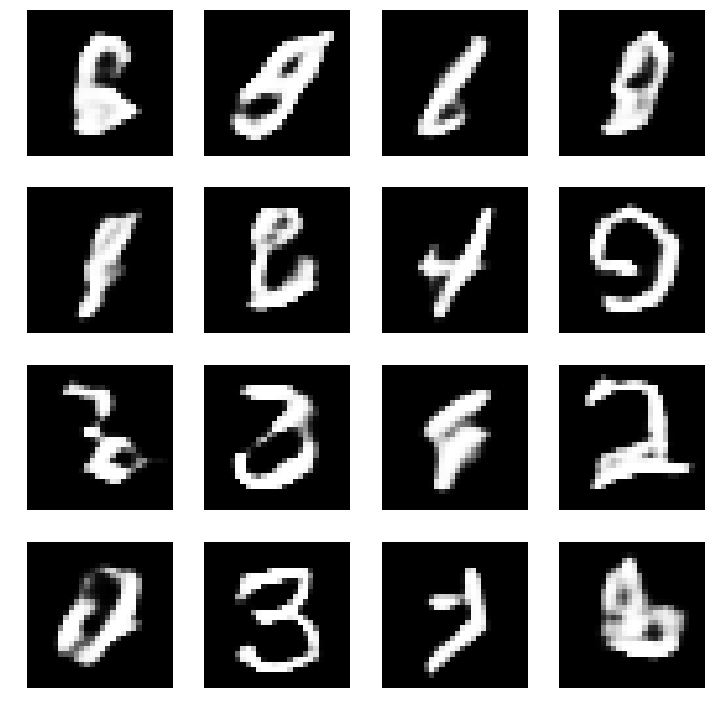

In [58]:
timer = ElapsedTimer()
train(train_epochs=1000, batch_size=256, save_interval=100) 
timer.elapsed_time()
plot_images(fake=True)
plot_images(fake=False, saveToFile=True)